# Logistic Regression Model
### Use model_input_file_v2.csv
### Features: game_speed, game_distance, anthropometrics (height, weight, body_fat_pct, etc)
### Target: is_injured (binary)

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

In [122]:
df = pd.read_csv("./model_input_v2.csv")

df.sample(5)

,PLAYER_ID,age,game_id,speed,distance,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,STANDING_REACH,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,is_injured
6,200794,30,21500001,3.98,2.38,78.25,258.0,85.50,105.5,9.7,NaN,NaN,0
17467,201960,30,21501202,3.94,1.14,78.25,207.2,82.00,105.0,6.3,NaN,NaN,0
15227,203477,25,21501045,3.97,1.98,71.00,188.4,76.50,94.5,5.9,8.25,9.5,0
359,202340,25,21500024,4.35,2.15,74.00,180.4,79.25,98.5,4.0,8.25,9.5,0
9470,2207,35,21500647,4.11,1.69,78.75,226.0,81.00,105.0,6.7,NaN,NaN,0


In [123]:
print("DataFrame shape:", df.shape)

injured_count = (df['is_injured'] == 1).sum()
print("Count of is_injured = 1:", injured_count)

not_injured_count = (df['is_injured'] == 0).sum()
print("Count of is_injured = 0:", not_injured_count)

DataFrame shape: (17867, 13)
Count of is_injured = 1: 312
Count of is_injured = 0: 17555


In [124]:
# Feature columns: game load (speed, distance), age, anthropometrics
ID_COLS = ["PLAYER_ID", "game_id"]
TARGET = "is_injured"

feature_cols = [c for c in df.columns if c not in ID_COLS and c != TARGET]
X = df[feature_cols].copy()
y = df[TARGET]

# Handle missing values: impute numeric with median
for c in X.select_dtypes(include=[np.number]).columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# Drop rows where target is missing (if any)
valid = y.notna()
X, y = X[valid], y[valid].astype(int)

print("Features:", feature_cols)
print("X shape:", X.shape, "| y shape:", y.shape)
print("Target mean (injury rate):", y.mean())

Features: ['age', 'speed', 'distance', 'HEIGHT_WO_SHOES', 'WEIGHT', 'WINGSPAN', 'STANDING_REACH', 'BODY_FAT_PCT', 'HAND_LENGTH', 'HAND_WIDTH']
X shape: (17867, 10) | y shape: (17867,)
Target mean (injury rate): 0.017462360776851177


In [125]:
# Train/test split (stratify on binary target for similar injury rate)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train size:", len(y_train), "| Test size:", len(y_test))
print("Train injury rate:", y_train.mean(), "| Test injury rate:", y_test.mean())

Train size: 13400 | Test size: 4467
Train injury rate: 0.01746268656716418 | Test injury rate: 0.017461383478844864


In [126]:
# Fit logistic regression (class_weight='balanced' for imbalanced injury rate)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_prob_train = model.predict_proba(X_train)[:, 1]
y_prob_test = model.predict_proba(X_test)[:, 1]

In [127]:
# Classification metrics
for name, y_true, y_pred, y_prob in [
    ("Train", y_train, y_pred_train, y_prob_train),
    ("Test", y_test, y_pred_test, y_prob_test),
]:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f}")

print("\nTest set classification report:")
print(classification_report(y_test, y_pred_test, target_names=["not_injured", "injured"]))

Train: Accuracy=0.6701, Precision=0.0345, Recall=0.6624, F1=0.0655, ROC-AUC=0.7262
Test: Accuracy=0.6714, Precision=0.0373, Recall=0.7179, F1=0.0709, ROC-AUC=0.7276

Test set classification report:
              precision    recall  f1-score   support

 not_injured       0.99      0.67      0.80      4389
     injured       0.04      0.72      0.07        78

    accuracy                           0.67      4467
   macro avg       0.51      0.69      0.44      4467
weighted avg       0.98      0.67      0.79      4467



In [128]:
# Predicted vs actual counts
print("Train set - predicted injured:", (y_pred_train == 1).sum())
print("Train set - actual injured:", y_train.sum())
print("Test set - predicted injured:", (y_pred_test == 1).sum())
print("Test set - actual injured:", y_test.sum())

Train set - predicted injured: 4496
Train set - actual injured: 234
Test set - predicted injured: 1502
Test set - actual injured: 78


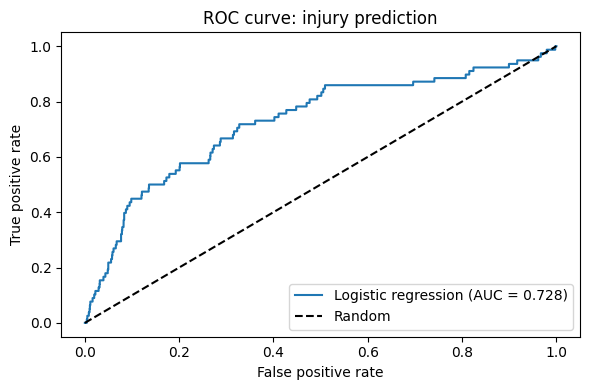

In [129]:
# ROC curve (test set)
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic regression (AUC = {roc_auc_score(y_test, y_prob_test):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.title("ROC curve: injury prediction")
plt.tight_layout()
plt.show()

In [130]:
# Coefficients (log-odds) and odds ratios
intercept = model.intercept_[0] if hasattr(model.intercept_, "__len__") else model.intercept_
coefs = model.coef_.ravel() if model.coef_.ndim > 1 else model.coef_
coef_df = pd.DataFrame({
    "feature": ["(intercept)"] + feature_cols,
    "coefficient": [intercept] + list(coefs),
})
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"]).reset_index(drop=True)
print(coef_df.to_string(index=False))

        feature  coefficient  odds_ratio
    (intercept)     8.231134 3756.092027
       distance    -1.039743    0.353546
    HAND_LENGTH    -0.836854    0.433071
     HAND_WIDTH     0.289245    1.335419
HEIGHT_WO_SHOES    -0.084959    0.918550
          speed    -0.039532    0.961240
   BODY_FAT_PCT     0.039250    1.040031
       WINGSPAN     0.016318    1.016452
            age     0.012803    1.012886
         WEIGHT     0.008157    1.008190
 STANDING_REACH     0.007638    1.007667


## Results and interpretation

### Bottom line
**This model is not useful in practice.** It has weak discriminative power and is not reliable for flagging injury risk.

### What the metrics show
- **Precision ~3–4%:** When the model predicts "injured," it is wrong almost all the time. Too many false positives to trust a positive prediction.
- **ROC-AUC ~0.73:** Modestly better than random (0.5). The features add some signal but not enough for reliable prediction.
- **F1 ~0.07:** Both precision and recall are poor; the "injured" class is not predicted in a usable way.
- **Recall ~66–72%:** The model catches about two-thirds of actual injuries, but at the cost of flagging a large number of non-injured games.

### Why performance is poor
- **Severe class imbalance:** Only ~1.7% of rows are injured. Predicting a rare event with limited predictors is hard even with `class_weight='balanced'`.
- **Limited signal in the features:** Game-level speed, distance, and anthropometrics are weak proxies for injury. Load history, type of movement, and other factors are not in this dataset.
- **Noisy target:** Predicting "is this game an injury game?" is inherently noisy—the same player could be high risk on many games and get injured only once.

### What would help
Richer features (e.g. cumulative load, injury history, sport-specific risk factors), a different target or formulation (e.g. risk over a window, or at player level), or a different model family might improve things. This baseline shows that these features alone are not enough for reliable injury prediction.